# Increase in Gases Compared to Temp

In [124]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import os, warnings
from scipy.signal import savgol_filter
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
ctrTemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalLandTemperaturesByCountry.csv')
co2 = pd.read_csv('../data/CO2emissions/co2.csv')
methane = pd.read_csv('../data/methane/methane.csv')
no2 = pd.read_csv('../data/no2/no2.csv')

In [3]:
def cleanData(df):
    data = []
    for each in df.values:
        info = each[0].split('\t')
        data.append(info)
    boo = DataFrame(data=data,columns= co2.columns.values[0].split('\t'))
    del boo['Country Code']
    del boo['Indicator Name']
    del boo['Indicator Code']
    dataset = DataFrame()
    countries = boo['Country Name'].unique()
    for country in countries:
        holder=boo[boo['Country Name']==country]
        for each in holder.columns[1:]:
            zoo=DataFrame()
            zoo['Country'] = holder['Country Name']
            zoo['Year'] = each
            zoo['Emissions'] = holder[each]
            dataset = dataset.append(zoo)
    dataset['Emissions'] = dataset['Emissions'].apply(lambda x:None if x=='' else float(x))
    dataset = dataset.dropna().reset_index(drop=True)
    return(dataset)

In [4]:
codata = cleanData(co2) #metric tons
codata.rename(columns={'Emissions':'CO2 Emissions'},inplace=True)
medata = cleanData(methane) #kt of CO2 equivalent
medata['Emissions'] = medata['Emissions'].apply(lambda x:x*1000)
medata.rename(columns={'Emissions':'Methane Emissions'},inplace=True)
nodata = cleanData(no2) #kt of CO2 equivalent
nodata['Emissions'] = nodata['Emissions'].apply(lambda x:x*1000)
nodata.rename(columns={'Emissions':'NO2 Emissions'},inplace=True)
gasData = pd.merge(codata,medata,on=['Country','Year'],how='outer')
gasData = pd.merge(gasData,nodata,on=['Country','Year'],how='outer')
# gasData.head()

In [44]:
gasData['Total Emissions'] = gasData['CO2 Emissions'] + gasData['NO2 Emissions'] + gasData['Methane Emissions']
exclusions = ['IDA','Low & middle income','World',
              'Middle income','IBRD','IDA total',
              'North America','South America','Europe',
              'Asia','Africa','income',
              'Antarcita','IDA','&','demographic','poor','Fragile','countries','OECD','area']
for each in exclusions:
    gasData = gasData[~gasData['Country'].str.contains(each)]
gasData.head()

,Country,Year,CO2 Emissions,Methane Emissions,NO2 Emissions,Total Emissions
0,Aruba,1986,2.868319,13847.2,6474.660,20324.728319
1,Aruba,1987,7.234964,14301.7,8943.996,23252.930964
2,Aruba,1988,10.026508,14549.9,11000.443,25560.369508
3,Aruba,1989,10.634733,14898.1,11871.481,26780.215733
4,Aruba,1990,27.850035,15176.8,11823.462,27028.112035


In [45]:
countryTemp = ctrTemp.dropna()
#List of continents
continents = ['North America','South America','Europe','Asia','Africa','Australia','Antarcita']
#Remove continents from country temp
countryTemp = ctrTemp[~ctrTemp['Country'].isin(continents)]
countryTemp = countryTemp[~countryTemp['Country'].str.contains('(Europe)')]
countryTemp = countryTemp.dropna()
countryTemp['dt'] = pd.to_datetime(countryTemp['dt'])
countryTemp['Year'] = countryTemp['dt'].apply(lambda x : x.strftime('%Y'))
yearTemp = countryTemp.groupby(['Country','Year']).mean().reset_index(drop=False)

In [46]:
def plotGases(zoo):
    holder = gasData[gasData['Country'] == zoo]
    plt.figure(figsize=(6.5,4))
    host = host_subplot(111, axes_class=AA.Axes)
    ax = host.twinx()
    ax2 = host.twinx()
    
    new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
    ax2.axis['right'] = new_fixed_axis(loc='right',axes=ax2,offset=(55,0))

    co=host.plot(holder['Year'],holder['CO2 Emissions'], label='CO2')
    me=ax.plot(holder['Year'],holder['Methane Emissions'], label='Methane')
    no=ax2.plot(holder['Year'],holder['NO2 Emissions'], label='NO2')
    
    host.set_title('Gas Emissions of '+zoo+' (Metric Tons of C02)')
    host.set_ylabel('CO2 Emissions')
    ax.set_ylabel('Methane Emissions')
    ax2.set_ylabel('NO2 Emissions')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    host.legend()
    
#     host.axis['left'].label.set_color(co.get_color())
#     ax.axis['right'].label.set_color(me.get_color())
#     ax2.axis['right'].label.set_color(no.get_color())

In [117]:
data = DataFrame()
for each in gasData['Country'].unique():
    holder = gasData[gasData['Country'] == each]
    holderAvg = holder['Total Emissions'].mean()
#     holder['AverageTemperature'] = holder['AverageTemperature'].apply(lambda x : x - holderAvg)
    trimHolder = holder[['Year']+['Total Emissions']]
    trimHolder = trimHolder.set_index('Year',drop=True)
    diffChange = trimHolder.diff(5)
#     diffChange = trimHolder.pct_change(5)
    diffChange = diffChange.dropna().reset_index(drop=False)
    diffChange['Country'] = each
    diffChange.rename(columns={'Total Emissions':'Emissions Change'},inplace=True)
    data = data.append(diffChange)
    
# data = data.sort_values('TempChange')
data['AbsEmissionsChange'] = data['Emissions Change'].apply(lambda x : abs(x))
data = data.sort_values('AbsEmissionsChange', ascending=False).reset_index(drop=True)
data = data.sort_values('AbsEmissionsChange',ascending=False).reset_index(drop=True)
# data=data.groupby('Country').max().sort_values('AbsEmissionsChange',ascending=False).reset_index(drop=False)
data.head()

,Year,Emissions Change,Country,AbsEmissionsChange
0,2002,-7.891164e+08,Indonesia,7.891164e+08
1,1997,7.572838e+08,Indonesia,7.572838e+08
2,2008,4.696222e+08,China,4.696222e+08
3,2006,4.592101e+08,Indonesia,4.592101e+08
4,2011,-4.457916e+08,Indonesia,4.457916e+08


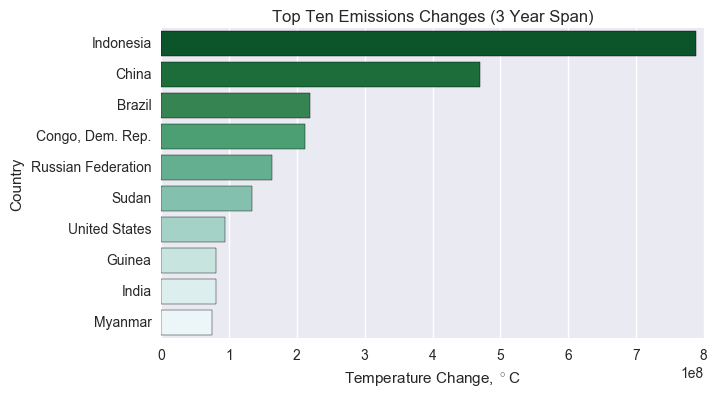

In [121]:
graphData=data.groupby('Country').max().sort_values('AbsEmissionsChange',ascending=False).reset_index(drop=False)
plt.figure(figsize=(7,4))
ax = sns.barplot(graphData['AbsEmissionsChange'][0:10],graphData['Country'][0:10],palette='BuGn_r')
ax.set_xlabel('Temperature Change, $^\circ$C')
ax.set_title('Top Ten Emissions Changes (3 Year Span)')
plt.savefig("./ana_4/topTenEmissions.pdf", bbox_inches='tight')

In [119]:
emData = DataFrame()
for each in data['Country'].unique()[:5]:
    temp = gasData[gasData['Country']==each]
    temp['Count']=1
    emData = emData.append(temp)
# emData.head()

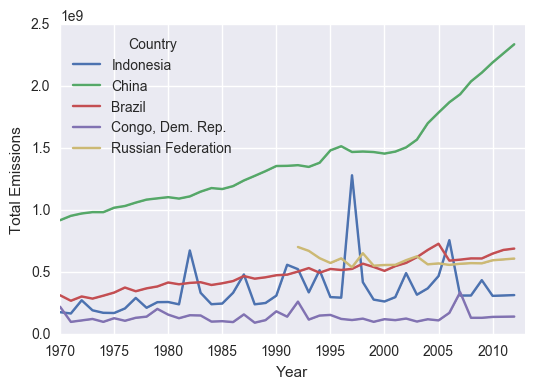

In [120]:
ax=sns.tsplot(time='Year', value='Total Emissions',unit='Count',condition='Country',data=emData)

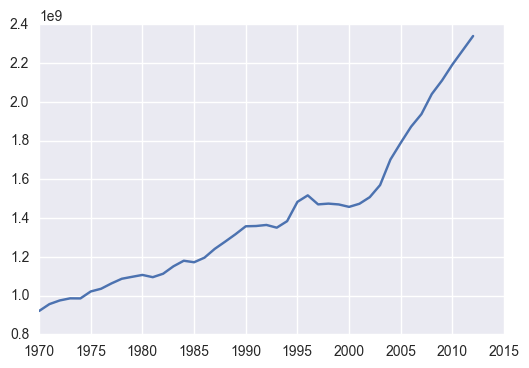

In [61]:
temp = gasData[gasData['Country']=='China']
plt.plot(temp['Year'],temp['Total Emissions'])

In [164]:
def plotGasVsTemp(zoo):
    gasholder = gasData[gasData['Country'] == zoo]
    yearholder = yearTemp[yearTemp['Country']==zoo]
    cut = str((int(gasholder['Year'].min())-10))
    yearholder = yearholder[yearholder['Year'] > cut]
#     yearholder = yearholder.sort_valu
    plt.figure(figsize=(6.5,4))
    host = host_subplot(111, axes_class=AA.Axes)
    ax = host.twinx()
    
#     new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
#     ax2.axis['right'] = new_fixed_axis(loc='right',axes=ax2,offset=(55,0))
#     gasholder['Total Emissions'] = savgol_filter(gasholder['Total Emissions'], 5, 1)
#     yearholder['AverageTemperature'] = savgol_filter(yearholder['AverageTemperature'], 3, 1)
    
    host.plot(gasholder['Year'],gasholder['Total Emissions'], label='CO2')
    ax.plot(yearholder['Year'],yearholder['AverageTemperature'], label='Temp')
#     ax2.plot(holder['Year'],holder['NO2 Emissions'], label='NO2')
    
    host.set_title('Gas Emissions vs Average Temperature of'+zoo )
    host.set_ylabel('Total Emissions')
    ax.set_ylabel('AverageTemp')
#     ax2.set_ylabel('NO2 Emissions')
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
#     ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    host.legend()
    
#     host.axis['left'].label.set_color(co.get_color())
#     ax.axis['right'].label.set_color(me.get_color())
#     ax2.axis['right'].label.set_color(no.get_color())

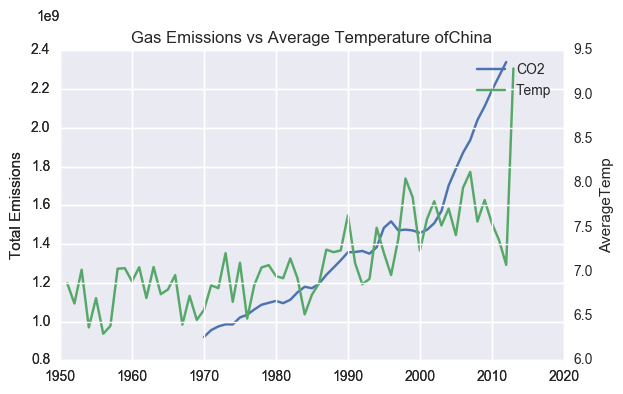

In [166]:
plotGasVsTemp('China')
plt.savefig("./ana_5/ChinaGasVsTemp.pdf", bbox_inches='tight')

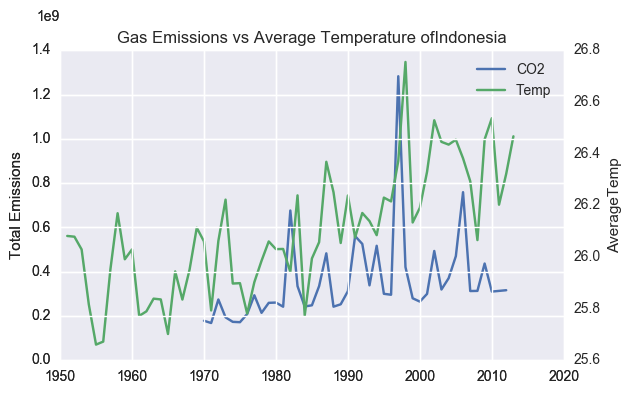

In [167]:
plotGasVsTemp('Indonesia')
plt.savefig("./ana_5/IndoGasVsTemp.pdf", bbox_inches='tight')